# DeepDream: hallucinate with a neural network

## [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ml4a/ml4a-guides/blob/ml4a.net/examples/models/deepdream.ipynb)

The `deepdream` module in ml4a contains a family of techniques which generate images that produce a desired activation state in a trained neural network. The most basic method initializes an image with random pixels, then iteratively optimizes the pixels using gradient descent to activate a single neuron or channel in the network. This is used to visualize the features the network has learned to detect (see [Erhan et al](https://pdfs.semanticscholar.org/65d9/94fb778a8d9e0f632659fb33a082949a50d3.pdf), [Simonyan et al](https://arxiv.org/pdf/1312.6034v2.pdf), and [Mahendran & Vedaldi](https://arxiv.org/pdf/1412.0035v1.pdf)) or to generate adversarial examples to identify flaws or vulnerabilities in the network (see [Nguyen et al](https://arxiv.org/pdf/1412.1897v4.pdf), and [Dosovitskiy & Brox](https://arxiv.org/pdf/1506.02753.pdf)). 

The technique originally called "DeepDream," developed by [Mordvintsev, Olah, and Tyka](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html), added the following innovation: instead of pre-specifying an objective activation state to optimize towards, extract the current activation state of some image, then iteratively change that image's pixels so as to amplify or increase the activations it already has. Further innovations included in this module are using masks to allocate regions of the output image for different objectives, regularization to improve image quality, and encasing the technique in a feedback loop to generate video.

The [deepdream module](https://github.com/genekogan/deepdream) is largely based on the original [Tensorflow example](https://github.com/tensorflow/tensorflow/blob/78ee8186db860185c7b73a9f70bf3a59530675dd/tensorflow/examples/tutorials/deepdream/deepdream.ipynb), which itself was based on Alex Mordvintsev's [Caffe-based code](https://github.com/google/deepdream). 

## Set up ml4a

If you don't already have ml4a and its dependencies installed, or you are opening this in Colab, first run the following cell.

In [ ]:
%tensorflow_version 1.x
!pip3 install --quiet git+https://github.com/ml4a/ml4a-guides.git@ml4a.net#egg=ml4a

## Running Deepdream

The simplest technique involves loading an image, and creating a config which has all the parameters of our desired optimization, including the objective (which we randomize below).

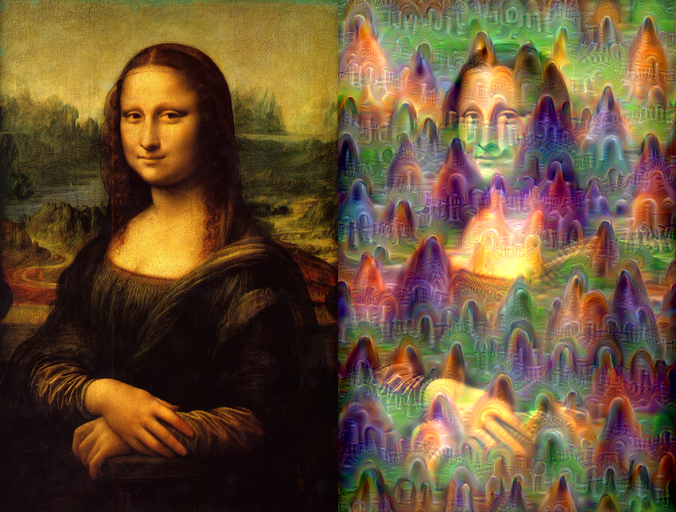

In [3]:
from ml4a import image
from ml4a.models import deepdream

channels = deepdream.get_random_favorites(deepdream.layers_m4, 1)

config = {
    'objective': channels,
    'num_octaves': 3,
    'octave_ratio': 1.333,
    'num_iterations': 30,
    'size': 512
}

input_img = image.load_image('https://upload.wikimedia.org/wikipedia/commons/6/6a/Mona_Lisa.jpg', 512)
output_img = deepdream.run(config, input_img)
image.display(image.concatenate_images([input_img, output_img]))

Looping through several more examples to see the variety, this time from a different layer.

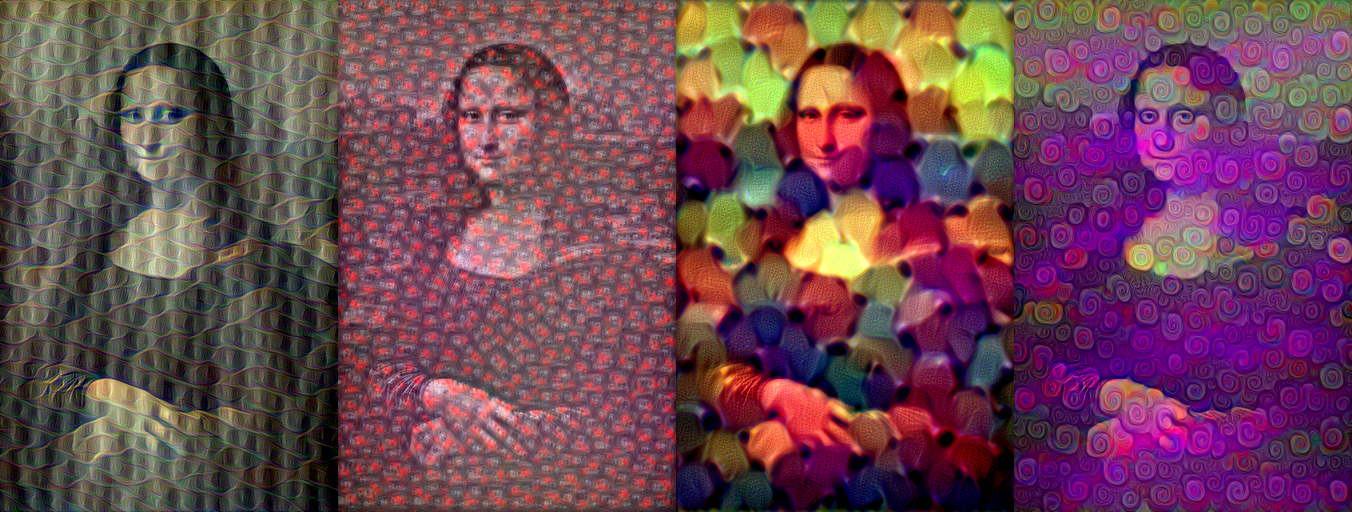

In [23]:
channels = deepdream.get_random_favorites(deepdream.layers_m3, 4)

output_imgs = []
for channel in channels:
    config['objective'] = channel
    output_img = deepdream.run(config, input_img)
    output_imgs.append(output_img)

image.display(output_imgs)

## Using masks

The `ml4a.canvas.mask` module allows for creating masks, which are structured as `numpy` matrices where all of the elements are between 0 and 1. During the optimization process, at each step, a `H * W` gradient is computed for each channel being optimized, where the gradient is the amount to add to the pixels of the `H * W` output image. If a mask is added to the config, the gradient is multiplied element-wise by the mask, attenuating the gradient.

One way this can be used is to give the deepdream config `N` objectives to optimize for, and a `H * W * N` sized mask, where each channel of the mask corresponds to one of the objectives. The masks can be composited in various ways to get interesting blending effects. For example, the following will produce a mask of overlapping diagonal rectangles.

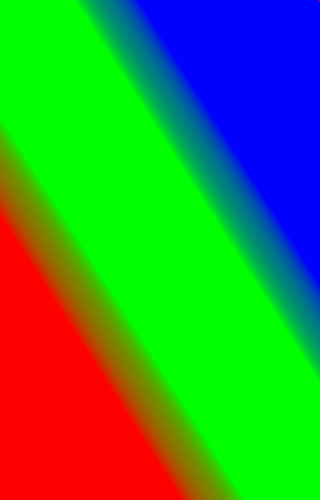

In [16]:
from ml4a.canvas import mask

size = (320, 500)

mask_config = {
    'type': 'rects',
    'size': size,
    'num_channels': 3, 
    'p1': (1.0, 0.0), 
    'p2': (0.0, 1.0), 
    'width': 3.0, 
    'period': 20,
    'blend': 0.15, 
    'reverse': True
}

mask_np = mask.get_mask(mask_config, t=0)
mask.view_mask(mask_np)

Another way to view the mask is to set the `merge` flag to `False`, which lets you visualize each channel of the mask separately. 

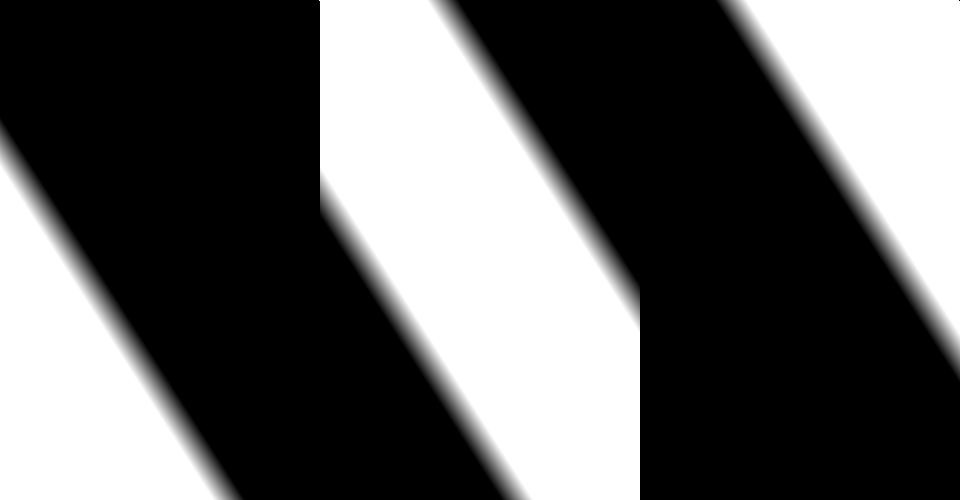

In [17]:
mask.view_mask(mask_np, merge=False)

We can apply this mask by assigning it to the `mask` variable of the deepdream config. The number of channel objectives we specify in the config (`config['objectives']`) must be equal to the number of channels in the mask, 3 in this case. 

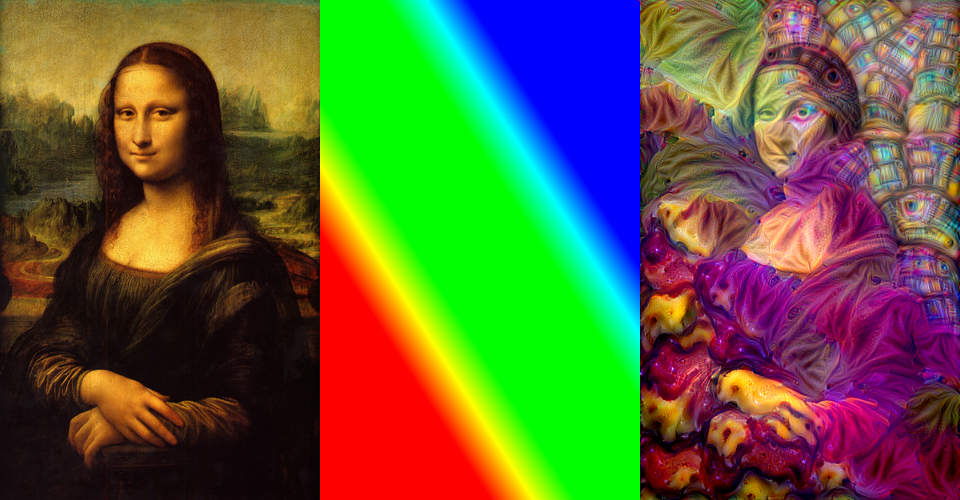

In [19]:
size = (320, 500)

mask_config = {
    'type': 'rects',
    'size': size, 
    'num_channels':3, 
    'p1': (1.0, 0.0), 
    'p2': (0.0, 1.0), 
    'width': 3.0, 
    'period': 20,
    'blend': 0.2, 
    'reverse': True
}

config = {
    'size': size,
    'masks': mask.get_mask(mask_config),
    'objective': [
        {'layer': 'mixed4c_pool_reduce', 'channel': 26},
        {'layer': 'mixed4d_3x3_bottleneck_pre_relu', 'channel': 7},
        {'layer': 'mixed4c_pool_reduce', 'channel': 6}
    ],
    'num_octaves': 3,
    'octave_ratio': 1.333,
    'num_iterations': 60,
    'lap_n': 20,
    'step': 1.25,
    'grayscale_gradients': False,
    'normalize_gradients': True
}

#img1 = image.random_image(size)
img1 = image.load_image('https://upload.wikimedia.org/wikipedia/commons/6/6a/Mona_Lisa.jpg', size)

img2 = deepdream.run(config, img1)

mask_img = mask.mask_to_image(mask.get_mask(mask_config))

image.display([img1, mask_img, img2])


Notice the gradual blending of features as you transition from one part of the canvas to another. Each objective shows up most strongly in that part of the canvas where its mask is high and the others low. In boundary zones where the mask is relatively equal for two of the objectives, the output produces features of both.

For more examples of how to generate and use masks using the `ml4a.canvas.mask` module, see [this example](https://github.com/ml4a/ml4a/blob/master/examples/canvas/masks.ipynb)

## Making video sequences

The Deepdream module takes an image as input, and produces an image as output. This gives us an opportunity to explore feedback loops as a way to generate sequences of frames for video.

If you simply take the output and run it again as the input without changing anything, it will simply reinforce the patterns it got in the first frame. The trick to get interesting effects is to make small changes between frames, either in the deepdream config or in the input image.

One example of the latter is to take the output image and distort it, either by stretching it, rotating it, translating it, or otherwise deforming it in some way before it goes back as the input for the next frame. We can achieve this using the `ml4a.canvas.canvas` module which lets us deform an image. See [this example](https://github.com/ml4a/ml4a/blob/master/examples/canvas/canvas.ipynb) for more info about the `canvas` module.

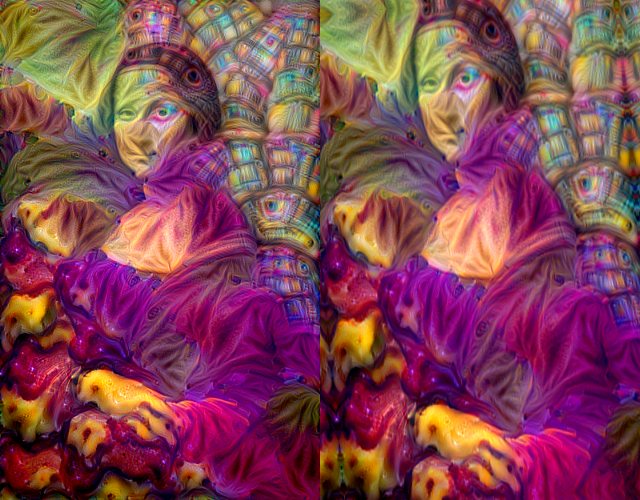

In [21]:
from ml4a.canvas import canvas

canvas_config = {
    'rot_const': 0.1,        # rotate 0.1 radians
    'stretch': (1.25, 1.0)    # stretch by 1.25x
}

img2_modified = canvas.modify_canvas(img2, canvas_config)

image.display([img2, img2_modified])

So now, we put the whole thing into a for loop, in which we repeatedly run the masked deepdream process on the previous output modified slightly by `canvas`. The below code shows the whole process for 50 frames, and we use a circular mask and 2 objectives to optimize.

In [25]:
num_frames = 50
size = (512, 512)

mask_config = {
    'size': size, 
    'type': 'arcs', 
    'center': (0.5, 0.5), 
    'num_channels': 2,
    'period': 30,
    'radius': 0.70710678118, 
    'blend': 0.15, 
    'inwards': False, 
    'reverse': False, 
    'normalize': False
}

dream_config = {
    'size': size,
    'objective': [
        {'layer': 'mixed3a_3x3_pre_relu', 'channel': 14},
        {'layer': 'mixed3b_pool_reduce_pre_relu', 'channel': 27}
    ],
    'num_octaves': 1,
    'octave_ratio': 1.333,
    'num_iterations': 24,
    'lap_n': 2,
    'step': 1.25,
    'normalize_gradients': True
}

canvas_config = {
    'center': (0.5, 0.5), 
    'shift': (0.0, -0.007), 
    'stretch': (1.0, 1.0), 
    'zoom': 1.0, 
    'expand': 0.0, 
    'rot_const': -0.001, 
    'rot_ang': 0.0, 
    'rot_dst': 0.0003
}

# start with a random image
img = image.random_image(size, bias=100.0)

# we will keep all the generated frames in memory.
# for longer sequences, best to save each image to disk and render video after
frames = []

# main loop
for f in range(0, num_frames):
    
    # set current mask
    config['masks'] = mask.get_mask(mask_config, t=f)
    
    # run deepdream on input image
    img = deepdream.run(dream_config, img, title='Frame %d/%d'%(f+1, num_frames))
    
    # save output image
    frames.append(img) 
    
    # distort output image and set it to be the next input image
    img = canvas.modify_canvas(img, canvas_config)


We can view the entire animation.

In [26]:
image.display(frames, animate=True)

Another nice thing to try is to use [`ml4a.models.basnet`](https://github.com/ml4a/ml4a/blob/master/examples/canvas/canvas.ipynb) to make a mask by doing foreground/background segmentation on an input image. If we use the same input image for deepdream as we use to generate the mask, we can use different objectives for the foreground and background.

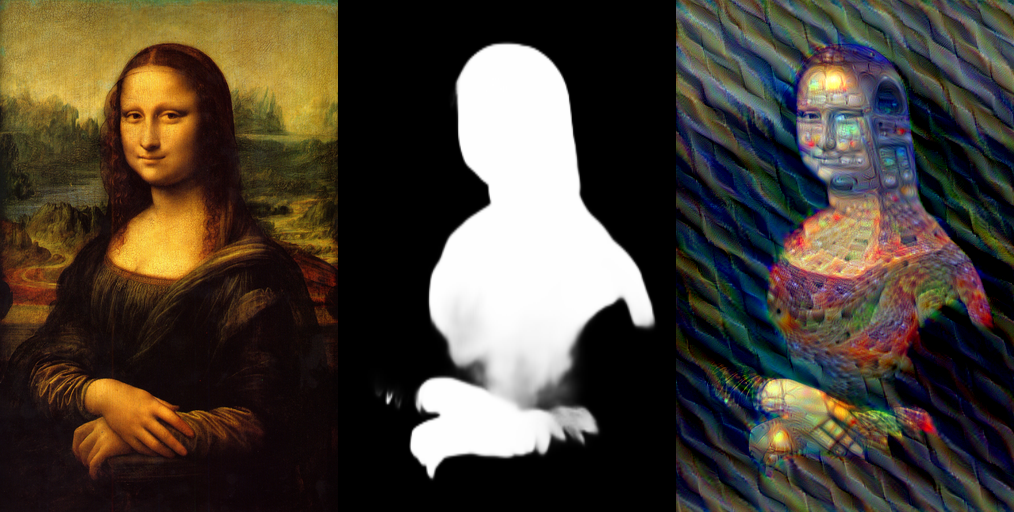

In [53]:
size = 512

img1 = image.load_image('https://upload.wikimedia.org/wikipedia/commons/6/6a/Mona_Lisa.jpg', size)

mask_config = {
    'type': 'image',
    'method': 'basnet',
    'image': img1
}

config = {
    'size': size,
    'masks': mask.get_mask(mask_config),
    'objective': [
        {'layer': 'mixed4d_3x3_bottleneck_pre_relu', 'channel': 29},
        {'layer': 'mixed3a_pool_reduce_pre_relu', 'channel': 3}
    ],
    'num_octaves': 3,
    'octave_ratio': 1.35,
    'num_iterations': 60,
    'lap_n': 20,
    'step': 1.25,
    'grayscale_gradients': False,
    'normalize_gradients': True
}

img2 = deepdream.run(config, img1)

mask_img = mask.mask_to_image(mask.get_mask(mask_config))

image.display([img1, mask_img, img2])